Assignment Details:

- ALi Nawaz
- nawazktk99@gmail.com
- 0335043653

# License Plate Detection Using YOLOv8

## Overview

This notebook demonstrates the steps to train a YOLOv8 model for detecting and localizing license plates in vehicle images. We will be using a custom dataset prepared via Roboflow in YOLOv8 format.

### Steps:

1. **Load and explore the dataset**
2. **Set up YOLOv8 environment**
3. **Train the YOLOv8 model**
4. **Evaluate model performance**
5. **Inference and visualize results**

## 1. Install Required Libraries

```bash
# Install ultralytics YOLOv8 package if not already installed
!pip install ultralytics
!pip install opencv-python matplotlib
```


## 2. Load and Explore Dataset


In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# Define dataset paths
train_images_dir = "dataset/train/images/"
train_labels_dir = "dataset/train/labels/"

val_images_dir = "dataset/valid/images/"
val_labels_dir = "dataset/valid/labels/"
# Load all images from the directory
train_images = [
    os.path.join(train_images_dir, img)
    for img in os.listdir(train_images_dir)
    if img.endswith(".jpg")
]
val_images = [
    os.path.join(val_images_dir, img)
    for img in os.listdir(val_images_dir)
    if img.endswith(".jpg")
]

# Print dataset size
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")

Number of training images: 210
Number of validation images: 60


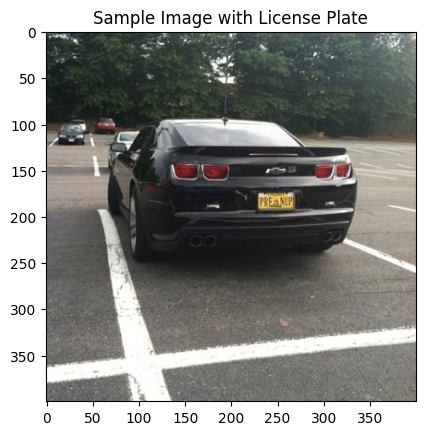

In [2]:
# Visualize a sample image from the dataset
sample_image_path = train_images[0]
sample_image = cv2.imread("dataset/test/images/Cars2_png.rf.ad5d791b8e4b05d295b4ce0a8a3ce6e2.jpg")
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title("Sample Image with License Plate")
plt.show()

### Visualize Image with Lable


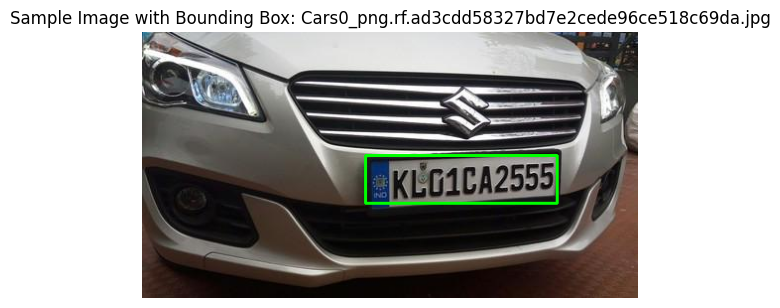

In [3]:
# List all images in the training directory
train_images = os.listdir(train_images_dir)

# Choose a sample image (e.g., the first image)
sample_image_name = train_images[0]
sample_image_path = os.path.join(train_images_dir, sample_image_name)

# Load the corresponding label file
label_file_name = sample_image_name.replace(".jpg", ".txt")
label_file_path = os.path.join(train_labels_dir, label_file_name)

# Load and visualize the sample image
sample_image = cv2.imread(sample_image_path)
image_height, image_width = sample_image.shape[:2]

# Read the label file
with open(label_file_path, "r") as file:
    labels = file.readlines()

# Plot the image and bounding boxes
for label in labels:
    # Each label is in the format: <class_id> <x_center> <y_center> <width> <height>
    class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())

    # Convert normalized coordinates to pixel values
    x_center *= image_width
    y_center *= image_height
    bbox_width *= image_width
    bbox_height *= image_height

    # Calculate the top-left corner of the bounding box
    x_min = int(x_center - (bbox_width / 2))
    y_min = int(y_center - (bbox_height / 2))

    # Calculate the bottom-right corner of the bounding box
    x_max = int(x_center + (bbox_width / 2))
    y_max = int(y_center + (bbox_height / 2))

    # Draw the bounding box on the image (green with 2px thickness)
    cv2.rectangle(sample_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Convert the image from BGR (OpenCV) to RGB (for matplotlib)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title(f"Sample Image with Bounding Box: {sample_image_name}")
plt.axis("off")  # Hide axis
plt.show()

## 3. Load the YOLOv8 Model


In [4]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (YOLOv8n for nano version or YOLOv8m for medium)
model = YOLO(
    "yolov8x.pt"
)  # You can choose yolov8s.pt, yolov8m.pt, etc., based on the size you need

# Display model architecture
model.model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(400, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
    

In [5]:
model.info()

YOLOv8x summary: 365 layers, 68229648 parameters, 0 gradients, 258.5 GFLOPs


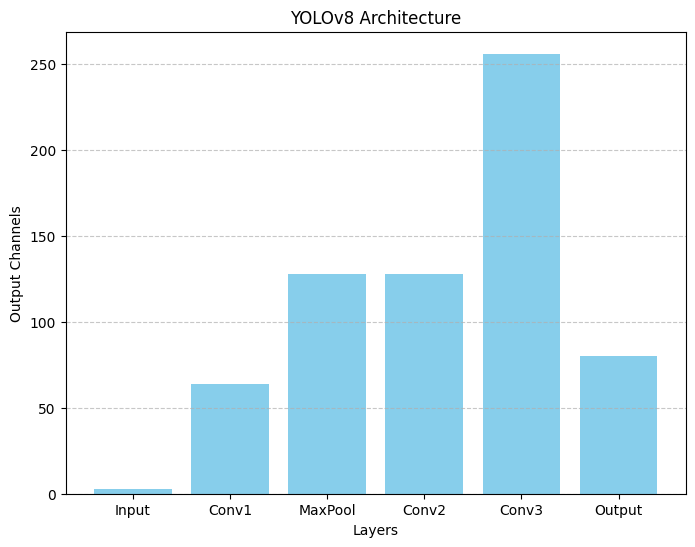

In [6]:
import matplotlib.pyplot as plt


def plot_yolov8_architecture():
    plt.figure(figsize=(8, 6))
    plt.title("YOLOv8 Architecture")
    plt.xlabel("Layers")
    plt.ylabel("Output Channels")

    layers = ["Input", "Conv1", "MaxPool", "Conv2", "MaxPool", "Conv3", "Output"]
    channels = [3, 64, 64, 128, 128, 256, 80]  # Example channel sizes

    plt.bar(layers, channels, color="skyblue")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


# Call the function to plot the architecture
plot_yolov8_architecture()

## 4. Configure Dataset and Training Parameters


In [8]:
# YOLO expects a data.yaml file describing the dataset
data_config = {
    "train": train_images_dir,  # Path to training images
    "val": val_images_dir,  # Path to validation images
    "nc": 1,  # Number of classes (license plate detection is a single class problem)
    "names": ["license_plate"],  # Class names
}

# Save data config as yaml file
import yaml

with open("data.yaml", "w") as file:
    yaml.dump(data_config, file)

# Set training hyperparameters
epochs = 50  # Number of training epochs
batch_size = 48  # Batch size
img_size = 640  # Image size

## 5. Train the YOLOv8 Model


In [9]:
results = model.train(
    data="data.yaml",  # Path to the dataset configuration file
    epochs=epochs,  # Number of training epochs
    batch=batch_size,  # Corrected: Batch size
    imgsz=img_size,  # Image size for resizing during training
    name="yolov8_license_plate",  # Model name for saving checkpoints
    patience=10,  # Early stopping if no improvement after 10 epochs
    optimizer="Adam",  # Optimizer, e.g., 'Adam' for better convergence
    lr0=1e-3,  # Initial learning rate
    lrf=0.1,  # Final learning rate (learning rate scheduling)
    weight_decay=0.0005,  # Regularization for reducing overfitting
    momentum=0.937,  # Momentum for SGD optimizer, helps stabilize updates
    augment=True,  # Enable data augmentation (rotations, flips, etc.)
    dropout=0.0,  # Add dropout to avoid overfitting (optional)
    cache=True,  # Cache dataset in RAM for faster access during training
    verbose=True,  # Verbose mode to see more details during training
)

yolo\engine\trainer: task=detect, mode=train, model=yolov8x.yaml, data=data.yaml, epochs=50, patience=10, batch=48, imgsz=640, save=True, cache=True, device=None, workers=8, project=None, name=yolov8_license_plate, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=True, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=True, agnostic_nms=False, retina_masks=False, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, workspace=4, nms=False, lr0=0.001, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmu

## 6. Evaluate Model Performance


In [13]:
val_results = model.val(data="data.yaml")
print(val_results)


Ultralytics YOLOv8.0.3  Python-3.10.14 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
Fusing layers... 
Model summary: 268 layers, 68124531 parameters, 16515 gradients
val: Scanning D:\code\work\ANPR-App\dataset\valid\labels... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:05<00:00, 10.65it/s]
val: WARNING  Cache directory D:\code\work\ANPR-App\dataset\valid is not writeable: [WinError 183] Cannot create a file when that file already exists: 'D:\\code\\work\\ANPR-App\\dataset\\valid\\labels.cache.npy' -> 'D:\\code\\work\\ANPR-App\\dataset\\valid\\labels.cache'
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]
                   all         60         64      0.804      0.781      0.822      0.473
Speed: 5.2ms pre-process, 15.7ms inference, 0.0ms loss, 1.2ms post-process per image


None


## 7. Inference and Visualization


Ultralytics YOLOv8.0.3  Python-3.10.14 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
Fusing layers... 
Model summary: 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs
image 1/1 D:\code\work\ANPR-App\dataset\test\images\Cars9_png.rf.ab2a94830c4e1b11aa2611a3f3ee0212.jpg: 512x640 1 license_plate, 63.4ms
Speed: 1.0ms pre-process, 63.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


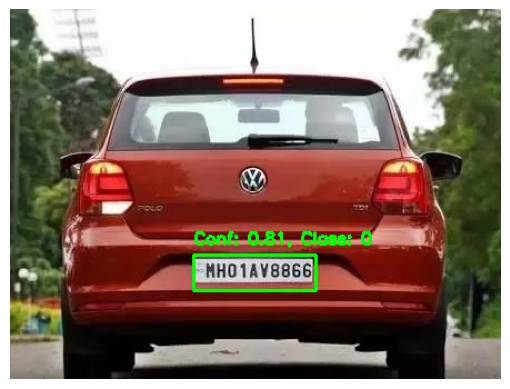

In [25]:
# Import necessary libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained YOLOv8 model (your fine-tuned model)
model = YOLO(r"runs\detect\yolov8_license_plate\weights\best.pt")  # Load your fine-tuned weights

# Run inference on an image
results = model(r"dataset\test\images\Cars9_png.rf.ab2a94830c4e1b11aa2611a3f3ee0212.jpg")  # Replace with your image path

# Load the original image using OpenCV
image = cv2.imread(r"dataset\test\images\Cars9_png.rf.ab2a94830c4e1b11aa2611a3f3ee0212.jpg")

# Extract the tensor from results (it is already a tensor in your case)
tensor_result = results[0]  # This contains the bounding box, confidence, and class

# Loop through the tensor and extract the information
for item in tensor_result:
    x1, y1, x2, y2 = map(int, item[:4])  # Extract bounding box coordinates and convert to integers
    confidence = item[4].item()  # Extract confidence score
    class_id = int(item[5].item())  # Extract class ID

    # Draw bounding box on the original image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    label = f"Conf: {confidence:.2f}, Class: {class_id}"
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with bounding boxes using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')  # Hide axis for better visualization
plt.show()


## 8. Post-processing and Performance Metrics


Ultralytics YOLOv8.0.3  Python-3.10.14 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
Fusing layers... 
Model summary: 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs
image 1/1 D:\code\work\ANPR-App\dataset\test\images\Cars9_png.rf.ab2a94830c4e1b11aa2611a3f3ee0212.jpg: 512x640 1 license_plate, 78.8ms
Speed: 0.0ms pre-process, 78.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


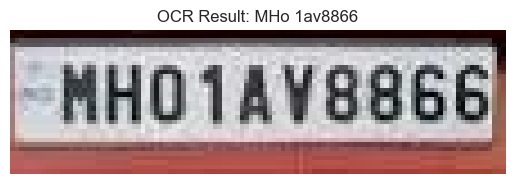

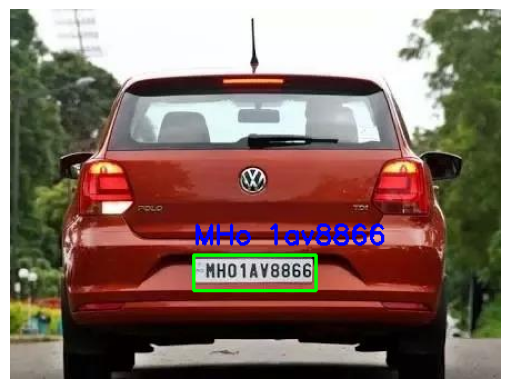

In [27]:
# Import necessary libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import easyocr

# Load the pre-trained YOLOv8 model (your fine-tuned model)
model = YOLO(r"runs\detect\yolov8_license_plate\weights\best.pt")  # Load your fine-tuned weights

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)  # You can change language if needed

# Run inference on an image
results = model(r"dataset\test\images\Cars9_png.rf.ab2a94830c4e1b11aa2611a3f3ee0212.jpg")  # Replace with your image path

# Load the original image using OpenCV
image = cv2.imread(r"dataset\test\images\Cars9_png.rf.ab2a94830c4e1b11aa2611a3f3ee0212.jpg")

# Extract the tensor from results (it is already a tensor in your case)
tensor_result = results[0]  # This contains the bounding box, confidence, and class

# Loop through the tensor and extract the information
for item in tensor_result:
    x1, y1, x2, y2 = map(int, item[:4])  # Extract bounding box coordinates and convert to integers
    confidence = item[4].item()  # Extract confidence score
    class_id = int(item[5].item())  # Extract class ID

    # Crop the ROI (Region of Interest) from the image using the bounding box
    roi = image[y1:y2, x1:x2]

    # Pass the cropped ROI to EasyOCR for text detection
    ocr_result = reader.readtext(roi)

    # Extract the detected text from the OCR result
    detected_text = " ".join([res[1] for res in ocr_result])

    # Display the cropped ROI with OCR text
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis('off')
    plt.title(f"OCR Result: {detected_text}")
    plt.show()

    # Draw bounding box on the original image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Overlay the detected text on the original image
    cv2.putText(image, detected_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Display the final image with bounding boxes and OCR text
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')
plt.show()


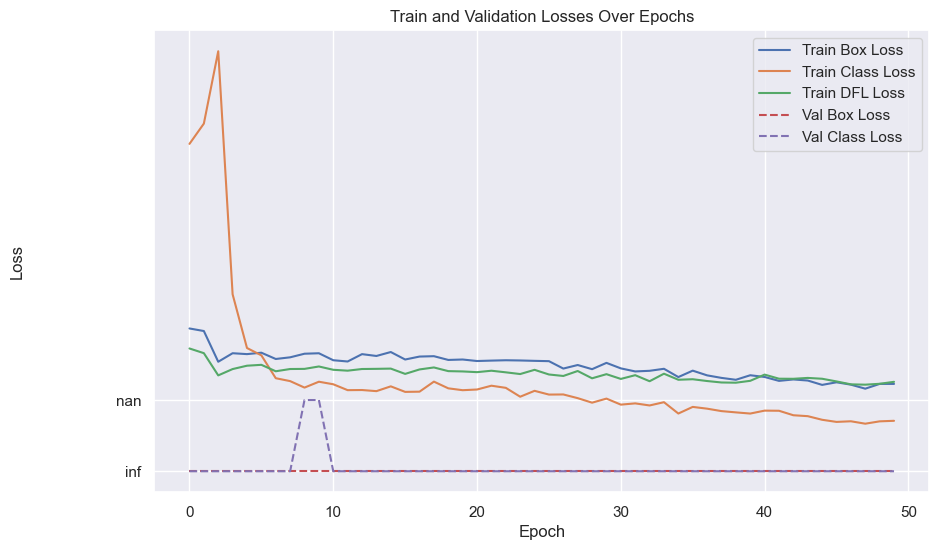

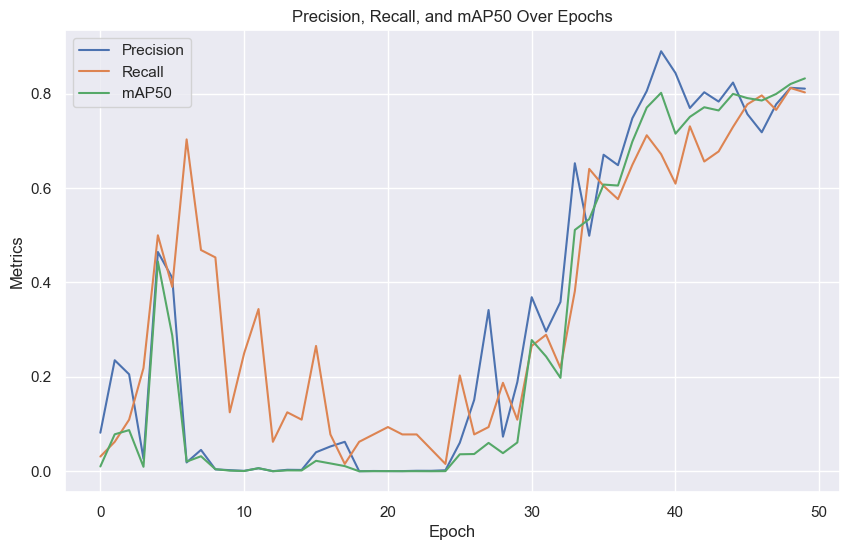

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file (update this path to your actual file path if needed)
file_path = r'runs\detect\yolov8_license_plate\results.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Clean the column names (if necessary)
df.columns = df.columns.str.strip()

# Plotting the train and validation losses over epochs
plt.figure(figsize=(10, 6))

# Plot train losses
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')

# Plot validation losses
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linestyle='--')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss', linestyle='--')

# Plot settings
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting mAP50, precision, and recall over epochs
plt.figure(figsize=(10, 6))

# Plot precision, recall, and mAP50
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')

# Plot settings
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and mAP50 Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
